In [1]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [2]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    recommendations: List[str]
    itinerary: str

In [3]:
from langchain_groq import ChatGroq
city_agent = ChatGroq(
    temperature=0,
    groq_api_key="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",
    model_name="llama-3.3-70b-versatile"
)

interest_agent = ChatGroq(
    temperature=0,
    groq_api_key="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",
    model_name="llama-3.3-70b-versatile"
)

itinerary_agent = ChatGroq(
    temperature=0,
    groq_api_key="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",
    model_name="llama-3.3-70b-versatile"
)


In [4]:
city_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a city expert. Recommend activities and locations in {city} for a day trip."),
    ("human", "What are the best places to visit in {city}?")
])

In [5]:
interest_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an interest parser. Categorize the user's interests: {interests} into activities like museums, parks, or cafes."),
    ("human", "Categorize my interests.")
])

In [6]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} using these recommendations: {recommendations} and these interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create a complete itinerary for my trip.")
])

In [7]:
def get_city_recommendations(city: str) -> List[str]:
    response = city_agent.invoke(city_prompt.format_messages(city=city))
    return response.content.split("\n")  # Split response into list of recommendations

def parse_interests(interests: str) -> List[str]:
    response = interest_agent.invoke(interest_prompt.format_messages(interests=interests))
    return [interest.strip() for interest in response.content.split(",")]

def create_itinerary(city: str, recommendations: List[str], interests: List[str]) -> str:
    response = itinerary_agent.invoke(itinerary_prompt.format_messages(
        city=city, recommendations="; ".join(recommendations), interests=", ".join(interests)))
    return response.content

In [8]:
workflow = StateGraph(PlannerState)

workflow.add_node("get_city_recommendations", get_city_recommendations)
workflow.add_node("parse_interest", parse_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("get_city_recommendations")

workflow.add_edge("get_city_recommendations", "parse_interest")
workflow.add_edge("parse_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

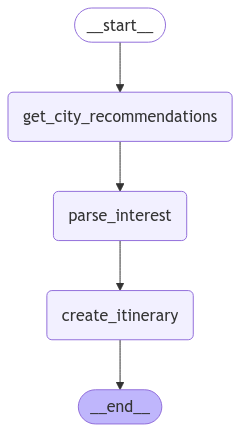

In [9]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

In [41]:

def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "city": "Lahore",
      "interests": ["historical"],
      "itinerary": "",
  }
  for output in app.stream(state):
    pass

In [ ]:
user_request = "I want to plan a day trip"
travel_planner(user_request)